## LAB № 04

# 1. Считайте из заданного набора данных репозитария UCI значения трех признаков и метки класса. 

In [1]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics.cluster import contingency_matrix
from sklearn.model_selection import cross_val_score
from urllib.request import urlopen
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from contextlib import closing
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
name = 'echocardiogram.data'
feat1 = 'feature1'
feat2 = 'feature2'
feat3 = 'feature3'

In [3]:
f1, f2, f3 = 4,7,6
target = 1

In [4]:
df = pd.read_csv("../data/echocardiogram.data",
                 delimiter=",", header=None, on_bad_lines='skip') 
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,11,0,71,0,0.260,9,4.600,14,1,1,name,1,0
1,19,0,72,0,0.380,6,4.100,14,1.700,0.588,name,1,0
2,16,0,55,0,0.260,4,3.420,14,1,1,name,1,0
3,57,0,60,0,0.253,12.062,4.603,16,1.450,0.788,name,1,0
4,19,1,57,0,0.160,22,5.750,18,2.250,0.571,name,1,0


In [5]:
df = df[[f1,f2,f3,target]]
df.head()

,4,7,6,1
0,0.260,14,4.600,0
1,0.380,14,4.100,0
2,0.260,14,3.420,0
3,0.253,16,4.603,0
4,0.160,18,5.750,1


# 2. Если среди меток класса имеются пропущенные значения, то удалите записи с пропущенными метками класса. Если в признаках имеются пропущенные значения, то замените пропущенные значения, используя метод, указанный в индивидуальном задании. Если пропущенные значения в наборе данных отсутствуют, то определите и удалите точки с выбросами при помощи стандартизованной оценки (Z-score). Выберите параметры стандартизованной оценки таким образом, чтобы выбросы составляли от 1% до 10% всех точек набора данных. Если количество различных меток классов превышает 4, то уменьшите количество классов.

In [6]:
df = df.replace('?', np.NaN)
print('Число записей = %d' % (df.shape[0]))
print('Число признаков = %d' % (df.shape[1]))
print('Число пропущенных значений:')
for col in df.columns:
    print('\t%s: %d' % (col,df[col].isna().sum()))

Число записей = 131
Число признаков = 4
Число пропущенных значений:
	4: 7
	7: 3
	6: 10
	1: 0


In [7]:
df.dropna(subset=[target], inplace=True)
df[f1] = df.groupby(target)[f1].transform(lambda x: x.fillna(x.median()))
df[f2] = df.groupby(target)[f2].transform(lambda x: x.fillna(x.median()))
df[f3] = df.groupby(target)[f3].transform(lambda x: x.fillna(x.median()))
print('Число пропущенных значений:')
for col in df.columns:
    print('\t%s: %d' % (col,df[col].isna().sum()))

Число пропущенных значений:
	4: 0
	7: 0
	6: 0
	1: 0


In [8]:
df = df.astype(float)

In [9]:
from scipy.stats import zscore

print(df.shape[0]*0.01),print(df.shape[0]*0.1)
z_scores = df[[f1,f2,f3]].apply(zscore)
z_threshold = 2.5
df_no_outliers = df[(np.abs(z_scores) < z_threshold).all(axis=1)]
print(f"Удалено {len(df) - len(df_no_outliers)} выбросов.")

1.31
13.100000000000001
Удалено 11 выбросов.


In [10]:
df[target].value_counts()

1
0.0    88
1.0    43
Name: count, dtype: int64

In [11]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
df[target] = lb_make.fit_transform(df[target])
df[target].value_counts()

1
0    88
1    43
Name: count, dtype: int64

# 3. Нормализуйте признаки набора данных методом, указанным в индивидуальном задании.

In [12]:
X = df[[f1,f2,f3]].astype(float)
y = df[target].astype(int)

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X = scaler.fit_transform(X)

# 4. Визуализируйте набор данных в виде точек трехмерного пространства с координатами, соответствующими трем признакам, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду набора данных. 

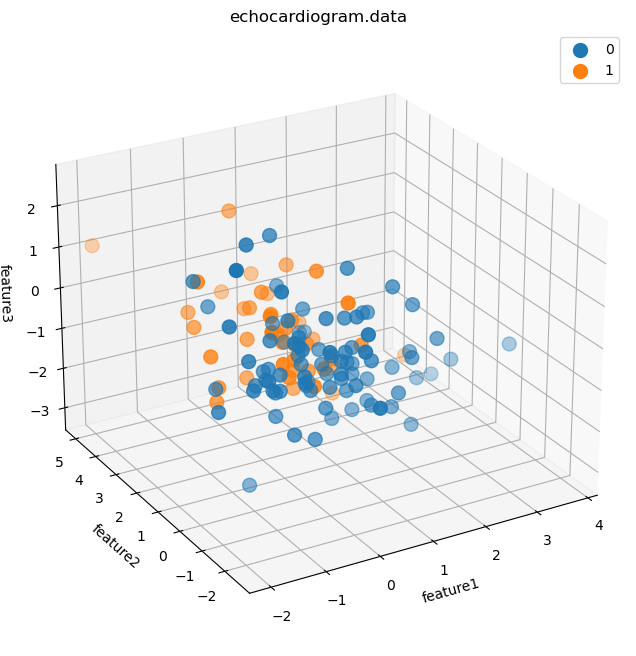

In [14]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

for i in (y.unique()):
    row_ix = np.where(y== i)
    a=X[row_ix, 0]
    b=X[row_ix, 1]
    c=X[row_ix, 2]
    ax.scatter(a, b, c,s=100,label=i)

plt.title(name)
ax.set_xlabel(feat1)
ax.set_ylabel(feat2)
ax.set_zlabel(feat3)
plt.legend()

ax.view_init(azim=-120, elev=25 );

# 5. Используя алгоритм снижения размерности данных, указанный в индивидуальном задании, уменьшите размерность признакового пространства до двух и визуализируйте набор данных в виде точек на плоскости, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду набора данных. 

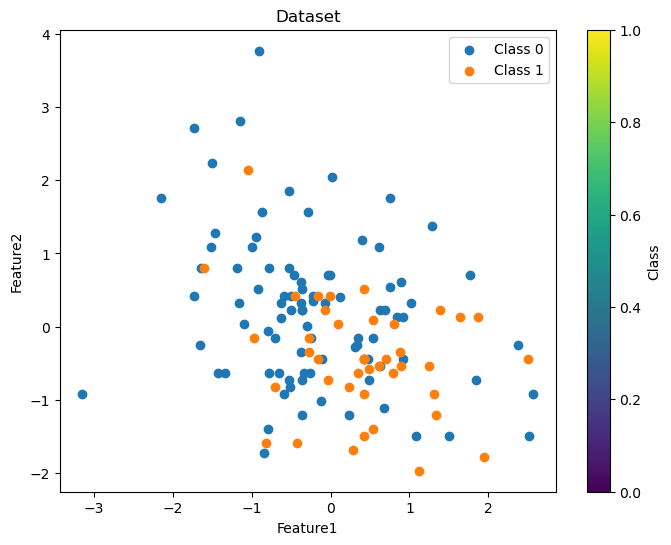

In [15]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)
feature_importances = clf.feature_importances_
top_k_indices = np.argsort(feature_importances)[::-1][:2]
X_2 = X[:, top_k_indices]

plt.figure(figsize=(8, 6))
cmap = plt.cm.get_cmap('viridis', len(np.unique(y)))
for class_label in np.unique(y):
    plt.scatter(X_2[y == class_label, 0], X_2[y == class_label, 1], cmap=cmap, marker='o', label=f'Class {class_label}')
plt.title('Dataset')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.colorbar(label='Class')
plt.legend()
plt.show()

# 6. Используя разделение набора данных из двух признаков на обучающую и тестовую выборки в соотношении 75% на 25%, проведите классификацию тестовой выборки с помощью метода К ближайших соседей для различных значений К<10 и определите оптимальное значение параметра К с минимальной долей ошибок. 

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.25, random_state=666)

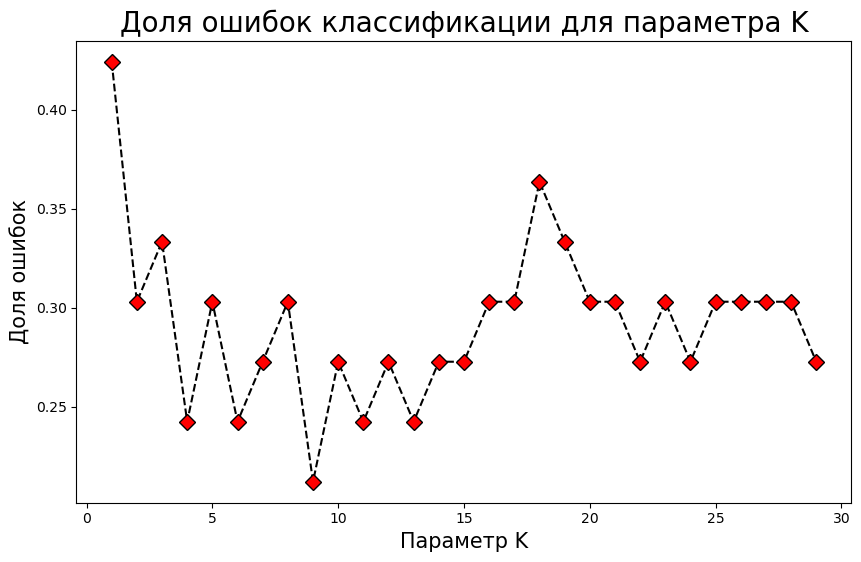

In [17]:
from sklearn.neighbors import KNeighborsClassifier

error_rate = []
for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
k = np.argmin(error_rate) + 1
plt.figure(figsize=(10,6))
plt.plot(range(1,30),error_rate,color='black', linestyle='dashed', marker='D',
         markerfacecolor='red', markersize=8)
plt.title('Доля ошибок классификации для параметра K', fontsize=20)
plt.xlabel('Параметр K',fontsize=15)
plt.ylabel('Доля ошибок',fontsize=15);

# 7. Для найденного значения K постройте и выведите на экран отчет о классификации и матрицу ошибок.

In [18]:
k

9

In [19]:
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

In [20]:
conf_mat=confusion_matrix(y_test,y_pred)
conf_mat

array([[20,  4],
       [ 3,  6]], dtype=int64)

In [21]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85        24
           1       0.60      0.67      0.63         9

    accuracy                           0.79        33
   macro avg       0.73      0.75      0.74        33
weighted avg       0.80      0.79      0.79        33



# 8. Создайте модели классификации точек набора данных из трех признаков на базе следующих классификаторов:
* наивного байесовского классификатора  
* классификатора метода К ближайших соседей для значения К, определенного в п. 6.

In [22]:
from sklearn.naive_bayes import GaussianNB
nbc = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=k) 

# 9. Используя указанный в индивидуальном задании метод валидации модели, проведите для набора данных из трех признаков оценку качества классификаторов из п. 8 относительно показателя, указанного в индивидуальном задании, и выведите на экран среднее значение и дисперсию этого показателя.

In [23]:
from sklearn.model_selection import StratifiedKFold
fold = StratifiedKFold(n_splits=10)

In [24]:
scoring = 'f1'

results_fold = cross_val_score(nbc, X, y, scoring=scoring,cv=fold)
print("Доля верных ответов_NBC (mean): %.2f%%" % (results_fold.mean()*100.0)) 
print("Доля верных ответов_NBC (var): %.2f%%" % (results_fold.var()*100.0)) 

results_fold_knn = cross_val_score(knn, X, y,scoring=scoring, cv=fold)
print("Доля верных ответов_KNN (mean): %.2f%%" % (results_fold_knn.mean()*100.0)) 
print("Доля верных ответов_KNN (var): %.2f%%" % (results_fold_knn.var()*100.0)) 

Доля верных ответов_NBC (mean): 45.40%
Доля верных ответов_NBC (var): 3.80%
Доля верных ответов_KNN (mean): 46.45%
Доля верных ответов_KNN (var): 3.70%


# 10. Определите, какой из классификаторов позволяет получить более высокое среднее значение показателя классификации, проведите классификацию точек набора данных этим классификатором и визуализируйте набор данных в виде точек трехмерного пространства с координатами, соответствующими трем признакам, отображая точки различных прогнозируемых классов разными цветами. Подпишите оси и рисунок, создайте легенду набора данных. 

In [25]:
if results_fold.mean() > results_fold_knn.mean():
    best_classifier = nbc
    print("NBC имеет более высокое среднее значение")
else:
    best_classifier = knn
    print("KNN имеет более высокое среднее значение")

best_classifier.fit(X, y)
y = pd.Series(best_classifier.predict(X).astype(int))

KNN имеет более высокое среднее значение


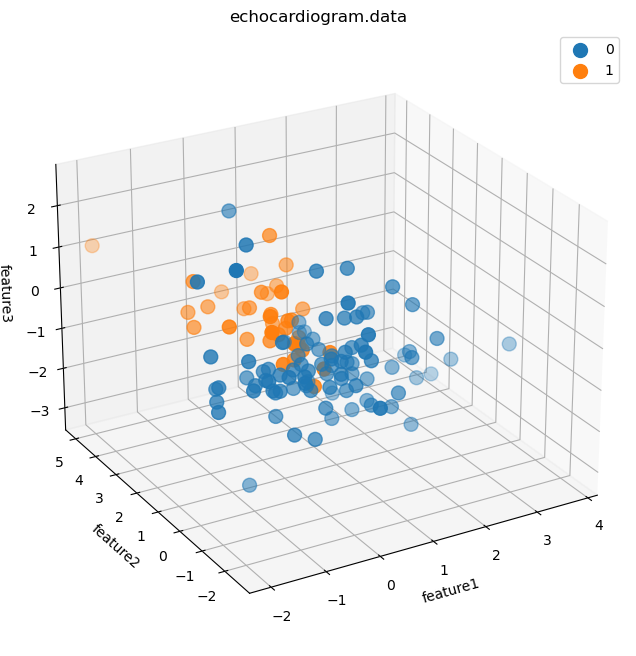

In [26]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

for i in (y.unique()):
    row_ix = np.where(y== i)
    a=X[row_ix, 0]
    b=X[row_ix, 1]
    c=X[row_ix, 2]
    ax.scatter(a, b, c,s=100,label=i)

plt.title(name)
ax.set_xlabel(feat1)
ax.set_ylabel(feat2)
ax.set_zlabel(feat3)
plt.legend()

ax.view_init(azim=-120, elev=25 );